In [1]:
import numpy as np
from scipy import stats, special
import matplotlib.pyplot as plt
import arviz as az

from ipywidgets import interact
import ipywidgets as ipyw
from IPython.display import IFrame

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}
</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "False",
              "progress": "False",
              "shortcut": "False",});

<center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Métodos numéricos par inferencia Bayesiana</h1>



<br>
<br>
<br>
<br>
<br>

## Computing the posterior distribution

* There are many ways to compute a posterior
    * <font color=gray> Conjugacy </font>
    * Laplace Method
    * Grid method
    * <font color=gray> Integrated Laplace approximation (INLA)</font>
    * <font color=gray> Variational Inference (VI) </font>
    * Markov Chain Monte Carlo (MCMC)
    * ...


* Only MCMC methods (and to less extend VI) are general enough

## Laplace approximation

* Compute the Maximum a posteriori (the mode of the posterior). $\theta_{MAP}$

* Compute the Hessian Matrix $\mathcal{H}$

* Approximate the posterior as $\mathcal{N}\left(\theta_{MAP}, \mathcal{H}^{-0.5}\right)$

* Use the Hessian matrix to estimate the covariance of the Gaussian

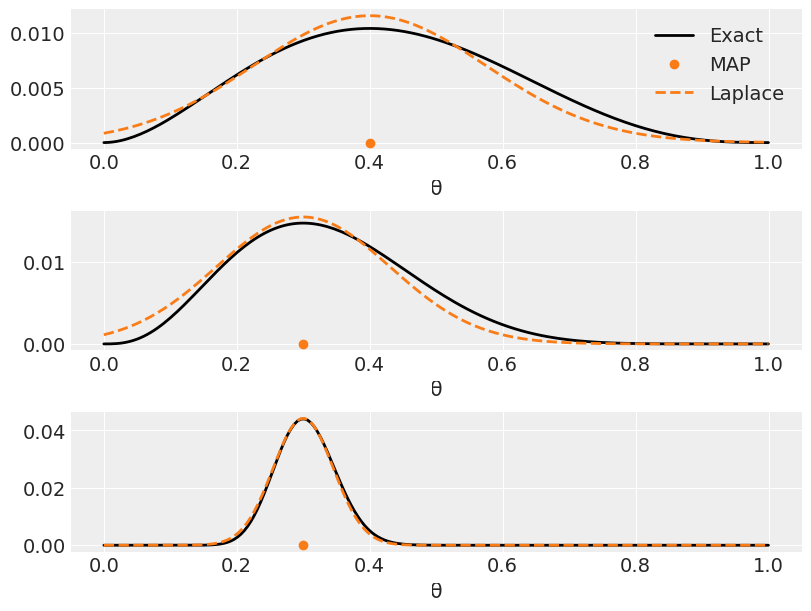

In [5]:
θ = np.linspace(0.0001, 0.9999, 200)
α = 1
β = 1

_, ax = plt.subplots(3, 1, constrained_layout=True, figsize=(8, 6))

for i, (N1, N) in enumerate([(2, 5), (3, 10), (30, 100)]):
    N0 = N - N1
    θ_MAP =  (α + N1-1) / (α + β + N-2)
    var =  ((α + N1) * (β + N0)) / ((α + N1 + β + N0)**2 * (α + N1 + β + N0 + 1))
    std = var**0.5

    post1 = stats.binom(N, θ).pmf(N1) * stats.beta(α, β).pdf(θ)
    post1 = post1 / np.sum(post1)
    post2 = stats.norm(θ_MAP, std).pdf(θ)
    post2 /= post2.sum()

    ax[i].plot(θ, post1, 'k', lw=2, label='Exact')
    ax[i].plot(θ_MAP, 0, 'oC1', label='MAP')
    ax[i].plot(θ, post2, 'C1--', lw=2, label='Laplace')
    ax[i].set_xlabel('θ')
ax[0].legend();

In [6]:
def posterior_grid(grid=10, α=1, β=1, heads=6, trials=9):
    grid = np.linspace(0, 1, grid)
    prior = stats.beta(α, β).pdf(grid)
    likelihood = stats.binom.pmf(heads, trials, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    _, ax = plt.subplots(1, 3, sharex=True, figsize=(16, 4))
    ax[0].set_title('heads = {}\ntrials = {}'.format(heads, trials))
    for i, (e, e_n) in enumerate(zip([prior, likelihood, posterior], ['prior', 'likelihood', 'posterior'])):
        ax[i].set_yticks([])
        ax[i].plot(grid, e, 'o-', label=e_n)
        ax[i].legend(fontsize=14)

interact(posterior_grid, grid=ipyw.IntSlider(min=2, max=100, step=1, value=15), α=ipyw.FloatSlider(min=1, max=7, step=1, value=1), β=ipyw.FloatSlider(
    min=1, max=7, step=1, value=1), heads=ipyw.IntSlider(min=0, max=20, step=1, value=6), trials=ipyw.IntSlider(min=0, max=20, step=1, value=9));

interactive(children=(IntSlider(value=15, description='grid', min=2), FloatSlider(value=1.0, description='α', …

* El principal problema del  método de la grilla es que no escala con las dimensión $d$ del problema.


* *Rapidamente* no encontramos con que la mayoría de los puntos de la grilla corresponden a puntos cuya contribución es practicamente nula.


* Esto está relacionado con la _maldición de la dimensionalidad_ o _concentración de la medida_, cosas como que todo el volumen de una hyperesfera está en la "cáscara".


* Por lo tanto hacen falta aproximaciones menos *naive*

## Cadenas de Markov (CM)

Una CM  es un proceso estocástico $\{X_t\}_{t\ge 0}$ con valores en un espacio de estados $E$ y que cumple:

$$
P\left(X_{t+s}=j|X_{t}=i,X_{t_1}=j_1, \cdots, X_{t_k}=j_{k} \right)= P\left(X_{t+s}=j|X_{t}=i\right),
$$

para cualquier $k$, $0\leq t_1 < t_2 < \cdots < t$ y para todos los posibles valores de $j_1, j_2, \cdots, j_k, i, j \in E$.

Es un proceso que tiene memoria corta, la distribución condicional de $X_n$ dada la historia de la cadena $X_0, X_1, \cdots, X_{n-1}$ sólo depende del estado más reciente $X_{n-1}$. Es decir, dado el pasado, el futuro es condicionalmente independiente del pasado.

## Cadenas de Markov


$$P=\left[\begin{array}{ccc}
                      \text{0} & \text{1} & \text{0} \\
                      \text{0} & \text{0.1} & \text{0.9}\\
											\text{0.6} & \text{0.4} & \text{0}\end{array}
\right]$$

<center><img src="img/Cadena.pdf" width="200"></center>

## Algunas propiedades de CM

* Una cadena es **irreducible** si se  puede llegar de cualquier estado a otro con probabilidad no nula. 
* El estado $i$ es **periódico** de el período $k$ si todos los retornos a $i$ deben ocurrir en m\'ultiplos de $k$.
* El estado $i$  es **transitorio** si el número promedio de visitas a $i$, $E(\eta_{i})$, es finito y **recurrente** si $E(\eta_{\omega})=\infty$
* Una cadena de Markov se dice **homogénea** si la probabilidad de ir del estado $i$ al estado $j$ en un paso son estacionarias, es decir no depende del tiempo en el que se encuentra la cadena, esto es

$$P\left
(X_{t+s}=j|X_{t}=i\right)=P\left(X_{s}=j|X_{0}=i\right).$$

## Algunas propiedades de CM

<br>

* Si $X_t$ es una cadena de Markov homogénea, irreducible y recurrente positiva entonces existe una única **distribución invariante** $\pi$,  y para cualquier distribución inicial se cumple además que 

$$\lim_{t \to +\infty}P(X_t=x_j)=\pi_j.$$

* **Teorema Ergódico**: Si $X_t$ es una cadena de Markov homogénea, irreducible y recurrente entonces para toda función $f:E\rightarrow R^+$ se cumple que

$$\lim_{t \to +\infty}\frac{1}{t}\int_0^t f(X_t) dt=E_\pi\left(f(X_t)\right)=\sum_{j\in E}f(j)\pi_j.$$

## Familia de algoritmos para Markov Chain Monte Carlo 

<br>

* Técnica cuyo propósito general es generar muestras ajustadas a una distribución dada, en general de distribuciones dificiles de muestrear por otros métodos, incluidas distribuciones de grandes dimensiones.


* Simula una cadena de Markov irreducible y aperiódica (ergódica) para aproximar, asintóticamente, la distribución empírica $\pi$ (ej la distribución *a posteriori*).


* Dado que no existen garantías teóricas para muestras finitas en la práctica es necesario evaluar la calidad de las muestras obtenidas (veremos esto más adelante)

## MCMC

Supongamos que queremos simular valores de una distribución a posteriori $p(\theta \mid \textbf{y})$.

* Simulamos una CM con distribución estacionaria $p(\theta | \textbf{y})$.

* Cada valor simulado, $\theta_t$ depende únicamente de su predecesor, $\theta_{t-1}$.

* Si el algoritmo se implementa correctamente, la convergencia de la cadena está garantizada (asintóticamente) independientemente de cuáles sean los valores iniciales.

## Algoritmo de Metropolis-Hastings (MH)

El algoritmo MH simula una cadena de Markov cuya distribución estacionaria es $p(\theta | \textbf{y}) \propto p(\textbf{y} \mid \theta) p(\theta)$. 

0. Se comienza con un valor inicial $\theta_0$

1. Dado el valor actual, $\theta_t$, simular un valor candidato $\tilde{\theta}$, de una densidad propuesta, $q(\tilde{\theta} \mid \theta_t)$

2. Calcular la probabilidad de aceptar el valor generado,
$$ \alpha=\min\left\{ 1; \frac{p(\tilde{\theta} \mid \textbf{y}) \ q( \theta_t \mid \tilde{\theta})}
                     {p(\theta_t \mid \textbf{y}) \ q(\tilde{\theta} \mid \theta_t)}\right\}$$

3. Simular $u_r$ de una $\mathcal{U}(0, 1)$
4. $u_r < \alpha$, tomar $\theta_{t+1}= \tilde{\theta}$ (aceptar candidato). Si no, rechazar y tomar $\theta_{t+1}=\theta_t$
5. Volver a 1, hasta tener *suficientes* muestras

## Implementando MH

A continuación veremos una implementación muy simple del algoritmo de MH. Algunas aclaraciones

* El código tiene fines pedagógicos, no prentende ser una implementación eficiente

* Los cálculos están en escala logarítmica, ya que esto provee estabilidad numérica 

* Si la distribución de propuesta es simétrica (como una Gaussiana) al evaluar $\alpha$ no es necesario calcular el término $\frac{q( \theta_t \mid \tilde{\theta})}
                     {q(\tilde{\theta} \mid \theta_t)}$

In [7]:
# Generamos datos "de juguete"
np.random.seed(820)
data = stats.bernoulli(0.1).rvs(50)

In [8]:
def log_post(θ, Y, α=1, β=1):
    """
    Compute log posterior distribution for the model:
    
    Beta(α, β) prior
    Y ~ Bern(θ) likelihood
    """
    prior = stats.beta(α, β).logpdf(θ)
    like  = stats.bernoulli(θ).logpmf(Y).sum()
    return like + prior

In [9]:
n_ites = 1000
proposal_sd = 0.1  # probar varios valores de proposal_sd

# Valores iniciales
θ = 0
results = np.zeros(n_ites)
# precomputar valores
Δ = stats.norm(0, proposal_sd).rvs(n_ites)  # distribución de propuesta
u_r = np.log(stats.uniform().rvs(n_ites))  # valores para evaluar aceptación

for ite in range(n_ites):
    # Generar un valor candidato, perturbando el valor actual
    candidate = θ + Δ[ite]
    new_p = log_post(candidate, data)
    old_p = log_post(θ, data)
    α = new_p - old_p
    # Criterio de aceptación
    if α > u_r[ite]:
        θ = candidate

    results[ite] = θ

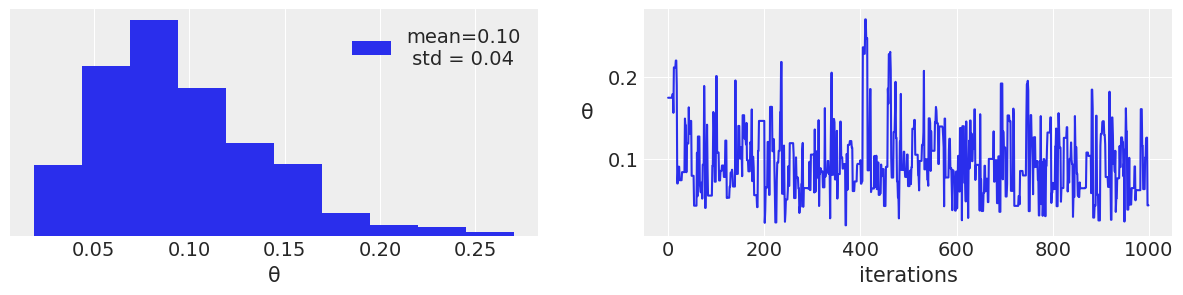

In [10]:
_, ax = plt.subplots(1, 2, figsize=(15, 3))
mean = results.mean()
std = results.std()
ax[0].hist(results, density=True, label=f'mean={mean:.2f}\n std = {std:.2f}')
ax[0].set_xlabel('θ')
ax[0].set_yticks([])
ax[0].legend()
ax[1].plot(results)
ax[1].set_ylabel('θ', rotation=0, labelpad=15)
ax[1].set_xlabel('iterations');

In [11]:
az.summary(results)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.096,0.043,0.019,0.163,0.003,0.002,194.0,162.0,226.0,173.0,NaN


### La eficiencia  de MH

* En la práctica MH tiene que ser *tuneado* para problemas particulares
* La distribución de propuesta es extremadamente importante para obtener una implementaicón eficiente
* Esto se puede automatizar (MH adaptativo)
    * Por lo general se utiliza una Gaussiana Multivariada
    * La matriz de covarianza se ajusta de tal forma que la tasa de aceptación sea de 0.234 (o _cerca_ )

## Otros métodos MCMC

Además del algoritmo Metropolis-Hastings existen otros algoritmos MCMC. Algunos de ellos son:

* Muestreo de Gibbs: un caso especial del algoritmo MH para espacios de estado de producto cartesiano (Ej.: imágenes)


* Monte-Carlo Hamiltoniano: Simula un hamiltoniano a partir del cual propone nuevos valores. Esto aumenta la tasa de aceptación (superior a 0.8) y reduce la correlación entre los sucesivos estados de muestreo (lo que disminuye la cantidad total de muestras necesarias, ya que se aproxima a muestras iid)


* Monte-Carlo Hamiltoniano adaptativo, como NUTS (y derivados). Calculan de forma automática hyper-parámetros del HMC, lo que permite una mayor eficiencia y mejores métodos de diagnóstico. 

In [13]:
IFrame(src='mcmc-demo-master/app.html#RandomWalkMH,standard', width=1200, height=600)